In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from PIL import Image
import skimage

sys.path.append(os.path.abspath('../'))
from utils import ext_transforms as et

from datasets import VOCSegmentation_polypGen2021 as polyGenSeg

In [2]:
train_transform = et.ExtCompose([
#              et.ExtRandomScale((0.5, 2.0)),
#             et.ExtRandomCrop(size=(512, 512), pad_if_needed=True),
#             et.ExtRandomHorizontalFlip(),
        ])

train_dst = polyGenSeg(
        root=f"/usr/not-backed-up/BayPolypGen-Benchmark/datasets/EndoCV2021/trainData_polypGen/",
        image_set='train_polypGen',
        download=False,
        transform=None,
        epi_dims=None,
        indices=False,
    )

/usr/not-backed-up/BayPolypGen-Benchmark/datasets/EndoCV2021/trainData_polypGen/trainVal/train_polypGen.txt


In [3]:
len(train_dst)

1159

Load epistemic uncertainties, true targets and predictions.

In [4]:
moment_path = "/usr/not-backed-up/BayPolypGen-Benchmark/moments/driven-sun-53/"

epis = np.load(f"{moment_path}epis.npy")
preds = np.load(f"{moment_path}preds.npy")
targets = np.load(f"{moment_path}targets.npy")

In [5]:
epis.shape

(1159, 512, 512)

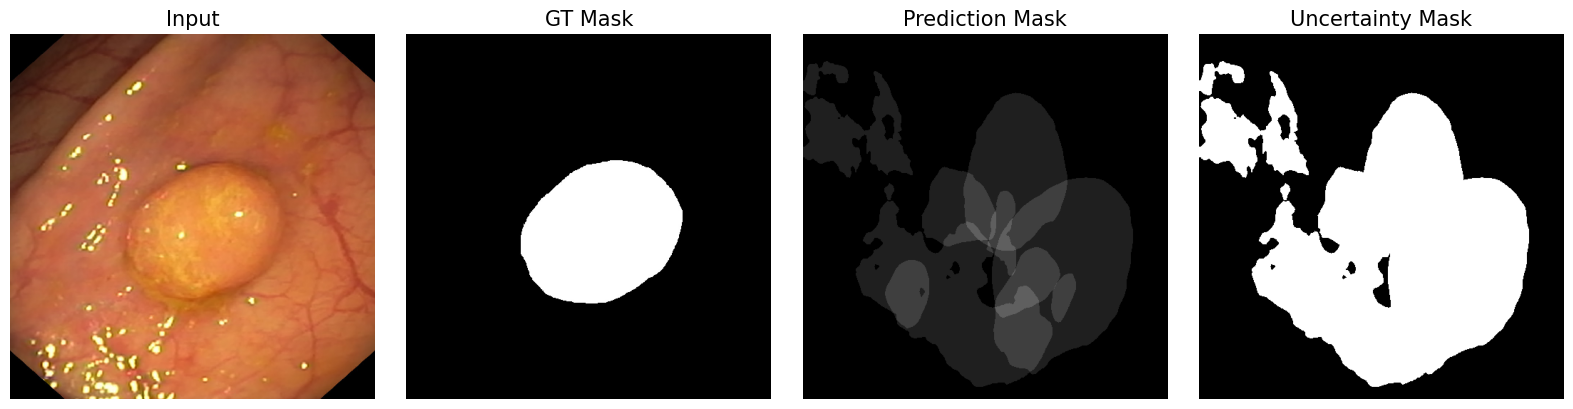

In [8]:
# loop through and display: original image (without transform), target mask, pred mask, and epi mask.

ROWS_TO_SHOW = 1
COLS_TO_SHOW = 4
fig, axes = plt.subplots(nrows=ROWS_TO_SHOW, ncols=COLS_TO_SHOW, figsize=(4*COLS_TO_SHOW, 4*ROWS_TO_SHOW))
axes = axes.flatten()

column_titles = ["Input", "GT Mask", "Prediction Mask", "Uncertainty Mask"]

for i in range(COLS_TO_SHOW):
    axes[i].set_title(column_titles[i], fontsize=15)


count = 0
for row in range(ROWS_TO_SHOW):
    images = [
        Image.open(train_dst.images[count]).convert('RGB').resize((512,512), resample=0), 
        Image.open(train_dst.masks[count]).convert('RGB').resize((512,512), resample=0),
        Image.fromarray(preds[count]),
        Image.fromarray(epis[count]),
    ]
    for col_id in range(4):
        axes[(row*4) + col_id].imshow(images[col_id])
        axes[(row*4) + col_id].axis('off')

    count += 1
    
plt.tight_layout()
plt.show()

In [7]:
moment_count = 7
threshold = 255./moment_count * moment_count/2. # majority moment agreement

preds[0].max() / 255.

0.375